# Modelo de classificação para gastos em saúde
(https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/linear-regression-health-costs-calculator)

Para fins de estudo outra abordagem para o mesmo problema foi pensada. Podemos pensar em faixas de gastos, tornando o problema de previsão em um problema de classificação. Assim podemos utilizar de modelos de classificação para identificar gastos.

# 1.Importando bibliotecas

In [1]:
import time

# Análise e visualização de dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pré-processamento
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Modelos e métricas
import shap
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Otimização de modelo
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel 
from sklearn.feature_selection import f_classif, mutual_info_regression

# Estilo de gráficos
plt.style.use('ggplot')

# Formatar saidas de tabelas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 2.Importando dataset

In [2]:
df = pd.read_csv('data/gastos_saude.csv')

# 3.Pré-Processamento

## Transformando gastos em faixa de gastos

In [10]:
df['expenses'].describe()

count    1338.000
mean    13270.422
std     12110.011
min      1121.870
25%      4740.288
50%      9382.030
75%     16639.915
max     63770.430
Name: expenses, dtype: float64

<Axes: xlabel='expenses', ylabel='Count'>

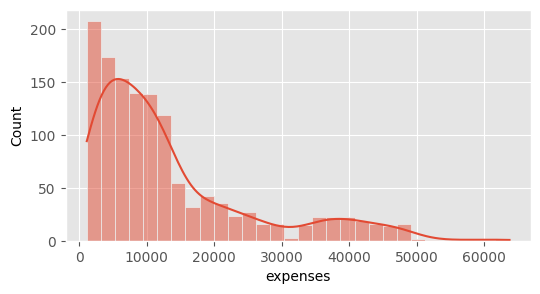

In [217]:
sns.histplot(df, x = 'expenses', kde = True)

Utilizaremos o qcut para classificar os gastos 

In [4]:
df['range_expenses'] = LabelEncoder().fit_transform(pd.qcut(df['expenses'], q=4, labels=False))

## Train Test Split

In [5]:
X_class = df[['age', 'bmi', 'smoker']]

Y_class = df['range_expenses']

x_train_class, x_test_class, y_train_class, y_test_class = train_test_split(X_class, Y_class, stratify = Y_class, random_state = 42)

## Pipeline

In [6]:
numericas_class = x_train_class.select_dtypes('number').columns
categoricas_class = x_train_class.select_dtypes('object').columns

In [7]:
print(numericas_class)
print(categoricas_class)

Index(['age', 'bmi'], dtype='object')
Index(['smoker'], dtype='object')


In [7]:
processador_num_class = Pipeline([('s_scaler', StandardScaler())])

processador_cat_class = Pipeline([('ohe', OneHotEncoder(drop = "first"))])

preprocessador_class = ColumnTransformer(transformers = [
    ("processador_num_class", processador_num_class, numericas_class),
    ("processador_cat_class", processador_cat_class, categoricas_class),
    ], remainder = 'passthrough', verbose_feature_names_out=False)

In [9]:
preprocessador_class

ColumnTransformer(remainder='passthrough',
                  transformers=[('processador_num_class',
                                 Pipeline(steps=[('s_scaler',
                                                  StandardScaler())]),
                                 Index(['age', 'bmi'], dtype='object')),
                                ('processador_cat_class',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first'))]),
                                 Index(['smoker'], dtype='object'))],
                  verbose_feature_names_out=False)

In [8]:
x_train_preproc_class = pd.DataFrame(preprocessador_class.fit_transform(x_train_class),
                                     columns = preprocessador_class.get_feature_names_out())

In [9]:
x_test_preproc_class = pd.DataFrame(preprocessador_class.transform(x_test_class),
                                    columns = preprocessador_class.get_feature_names_out())

# 4.Modelagem

## Árvore de Decisão - Modelo Base

In [10]:
# Iniciando contagem do tempo do modelo
tempo_inic_tree = time.time()

# Instanciando modelo
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, random_state = 42)

# tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, random_state = 42, ccp_alpha=0.0001)

# Fit do modelo nos dados
tree.fit(x_train_preproc_class, y_train_class)

# Fazendo previsões com os dados de teste
y_pred_tree = tree.predict(x_test_preproc_class)

# Finalizando contagem do tempo do modelo
tempo_final_tree = time.time()

# Calculo do tempo de de execução
tempo_total_tree = tempo_final_tree - tempo_inic_tree

Árvore de Decisão
Tempo de execução do modelo: 0.007 segundos
------------------------------------------------------
Acurácia: 0.791
Precision: 0.796
Recall: 0.791


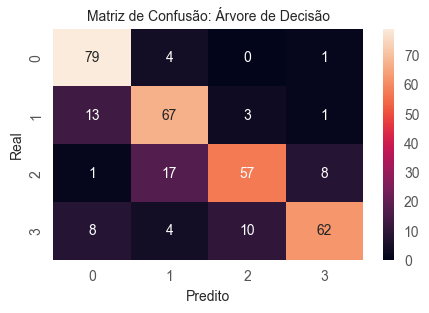

------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        84
           1       0.73      0.80      0.76        84
           2       0.81      0.69      0.75        83
           3       0.86      0.74      0.79        84

    accuracy                           0.79       335
   macro avg       0.80      0.79      0.79       335
weighted avg       0.80      0.79      0.79       335

------------------------------------------------------


In [11]:
print("="*54)
print(f'Árvore de Decisão')
print("="*54)
print(f"Tempo de execução do modelo: {round(tempo_total_tree, 3)} segundos")
print("-"*54)
print("Acurácia:", metrics.accuracy_score(y_test_class, y_pred_tree).round(3))
print("Precision:", metrics.precision_score(y_test_class, y_pred_tree, average = 'macro').round(3))
print("Recall:", metrics.recall_score(y_test_class, y_pred_tree, average = 'macro').round(3))

# Construindo matriz de confusão                                      
confusion_matrix = pd.crosstab(y_test_class, y_pred_tree, rownames = ['Real'], colnames = ['Predito'])
plt.figure(figsize=(5,3))
plt.title("Matriz de Confusão: Árvore de Decisão", fontsize=10)
sns.heatmap(confusion_matrix, annot=True)
plt.show()
print('-'*54)
print(metrics.classification_report(y_test_class, y_pred_tree))
print('-'*54)

In [53]:
x_train_preproc_class

,age,bmi,smoker_yes
0,1.383,0.205,0.000
1,1.312,0.638,0.000
2,0.818,0.555,0.000
3,-0.664,-1.077,0.000
4,1.736,-0.694,0.000
...,...,...,...
998,-0.170,-1.193,0.000
999,1.383,-0.844,0.000
1000,-0.594,-0.244,0.000
1001,1.595,1.437,0.000


In [54]:
x_preproc_class = pd.DataFrame(preprocessador_class.fit_transform(X_class),
                               columns = preprocessador_class.get_feature_names_out())

In [120]:
explainer = shap.TreeExplainer(tree, x_preproc_class)
shap_values = explainer.shap_values(x_preproc_class)

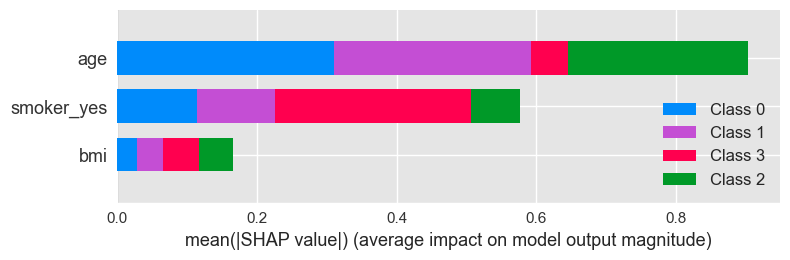

In [121]:
shap.summary_plot(shap_values, x_preproc_class)

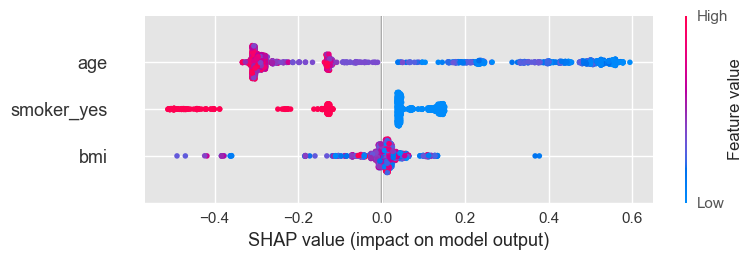

In [122]:
shap.summary_plot(shap_values[0], x_preproc_class.values, feature_names = x_preproc_class.columns)

### Random Forest

In [109]:
# Iniciando contagem do tempo do modelo
tempo_inic_rnd = time.time()

# Instanciando modelo
rnd = RandomForestClassifier(criterion = 'entropy', max_depth = 8, random_state = 42)

# rnd = DecisionrndClassifier(criterion = 'entropy', max_depth = 8, random_state = 42, ccp_alpha=0.0001)

# Fit do modelo nos dados
rnd.fit(x_train_preproc_class, y_train_class)

# Fazendo previsões com os dados de teste
y_pred_rnd = rnd.predict(x_test_preproc_class)

# Finalizando contagem do tempo do modelo
tempo_final_rnd = time.time()

# Calculo do tempo de de execução
tempo_total_rnd = tempo_final_rnd - tempo_inic_rnd

Random Forest
Tempo de execução do modelo: 0.244 segundos
------------------------------------------------------
Acurácia: 0.821
Precision: 0.831
Recall: 0.821


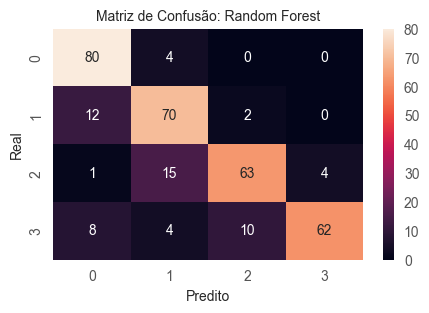

------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.95      0.86        84
           1       0.75      0.83      0.79        84
           2       0.84      0.76      0.80        83
           3       0.94      0.74      0.83        84

    accuracy                           0.82       335
   macro avg       0.83      0.82      0.82       335
weighted avg       0.83      0.82      0.82       335

------------------------------------------------------


In [110]:
print("="*54)
print(f'Random Forest')
print("="*54)
print(f"Tempo de execução do modelo: {round(tempo_total_rnd, 3)} segundos")
print("-"*54)
print("Acurácia:", metrics.accuracy_score(y_test_class, y_pred_rnd).round(3))
print("Precision:", metrics.precision_score(y_test_class, y_pred_rnd, average = 'macro').round(3))
print("Recall:", metrics.recall_score(y_test_class, y_pred_rnd, average = 'macro').round(3))

# Construindo matriz de confusão                                      
confusion_matrix = pd.crosstab(y_test_class, y_pred_rnd, rownames = ['Real'], colnames = ['Predito'])
plt.figure(figsize=(5,3))
plt.title("Matriz de Confusão: Random Forest", fontsize=10)
sns.heatmap(confusion_matrix, annot=True)
plt.show()
print('-'*54)
print(metrics.classification_report(y_test_class, y_pred_rnd))
print('-'*54)

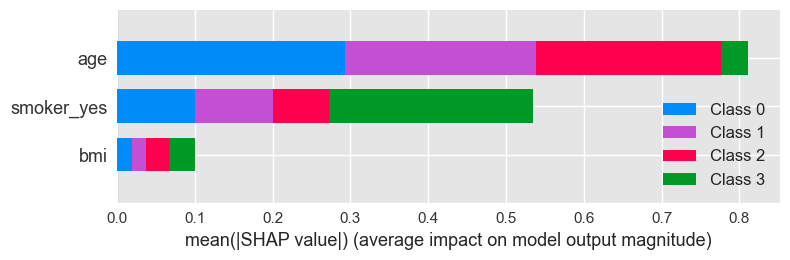

In [127]:
# load JS visualization code to notebook
shap.initjs()

# create a TreeExplainer object
explainer = shap.TreeExplainer(rnd)

shap_values = explainer.shap_values(x_test_preproc_class)

shap.summary_plot(shap_values, x_test_preproc_class)

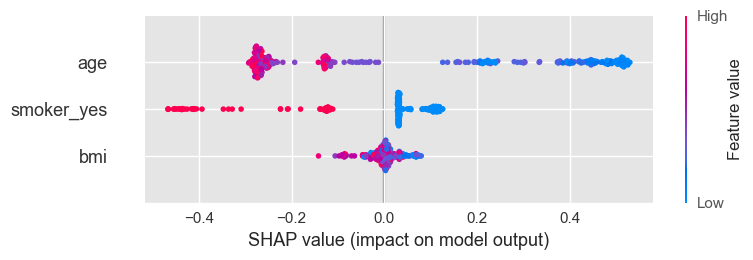

In [130]:
shap.summary_plot(shap_values[0], x_test_preproc_class)

### SVM

#### Linear

In [16]:
tempo_inic_svmlin = time.time()

svmlin = SVC(kernel = 'linear')

svmlin.fit(x_train_preproc_class, y_train_class)

y_pred_svmlin = svmlin.predict(x_test_preproc_class)

# Finalizando contagem do tempo do modelo
tempo_final_svmlin = time.time()

# Calculo do tempo de de execução
tempo_total_svmlin = tempo_final_svmlin - tempo_inic_svmlin

SVM - Linear
Tempo de execução do modelo: 0.03 segundos
------------------------------------------------------
Acurácia: 0.821
Precision: 0.826
Recall: 0.821


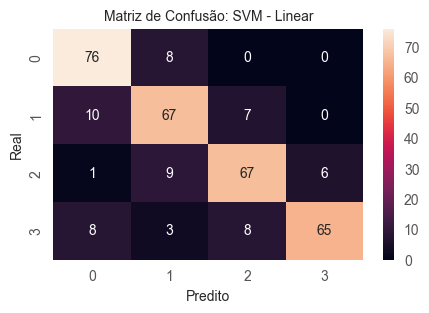

------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        84
           1       0.77      0.80      0.78        84
           2       0.82      0.81      0.81        83
           3       0.92      0.77      0.84        84

    accuracy                           0.82       335
   macro avg       0.83      0.82      0.82       335
weighted avg       0.83      0.82      0.82       335

------------------------------------------------------


In [17]:
print("="*54)
print(f'SVM - Linear')
print("="*54)
print(f"Tempo de execução do modelo: {round(tempo_total_svmlin, 3)} segundos")
print("-"*54)
print("Acurácia:", metrics.accuracy_score(y_test_class, y_pred_svmlin).round(3))
print("Precision:", metrics.precision_score(y_test_class, y_pred_svmlin, average = 'macro').round(3))
print("Recall:", metrics.recall_score(y_test_class, y_pred_svmlin, average = 'macro').round(3))

# Construindo matriz de confusão                                      
confusion_matrix = pd.crosstab(y_test_class, y_pred_svmlin, rownames = ['Real'], colnames = ['Predito'])
plt.figure(figsize=(5,3))
plt.title("Matriz de Confusão: SVM - Linear", fontsize=10)
sns.heatmap(confusion_matrix, annot=True)
plt.show()
print('-'*54)
print(metrics.classification_report(y_test_class, y_pred_svmlin))
print('-'*54)

#### RBF

In [18]:
tempo_inic_svmrbf = time.time()

svmrbf = SVC(kernel = 'rbf')

svmrbf.fit(x_train_preproc_class, y_train_class)

y_pred_svmrbf = svmrbf.predict(x_test_preproc_class)

# Finalizando contagem do tempo do modelo
tempo_final_svmrbf = time.time()

# Calculo do tempo de de execução
tempo_total_svmrbf = tempo_final_svmrbf - tempo_inic_svmrbf

SVM - RBF
Tempo de execução do modelo: 0.056 segundos
------------------------------------------------------
Acurácia: 0.83
Precision: 0.837
Recall: 0.83


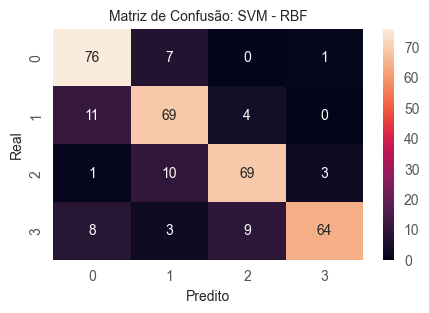

------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        84
           1       0.78      0.82      0.80        84
           2       0.84      0.83      0.84        83
           3       0.94      0.76      0.84        84

    accuracy                           0.83       335
   macro avg       0.84      0.83      0.83       335
weighted avg       0.84      0.83      0.83       335

------------------------------------------------------


In [19]:
print("="*54)
print(f'SVM - RBF')
print("="*54)
print(f"Tempo de execução do modelo: {round(tempo_total_svmrbf, 3)} segundos")
print("-"*54)
print("Acurácia:", metrics.accuracy_score(y_test_class, y_pred_svmrbf).round(3))
print("Precision:", metrics.precision_score(y_test_class, y_pred_svmrbf, average = 'macro').round(3))
print("Recall:", metrics.recall_score(y_test_class, y_pred_svmrbf, average = 'macro').round(3))

# Construindo matriz de confusão                                      
confusion_matrix = pd.crosstab(y_test_class, y_pred_svmrbf, rownames = ['Real'], colnames = ['Predito'])
plt.figure(figsize=(5,3))
plt.title("Matriz de Confusão: SVM - RBF", fontsize=10)
sns.heatmap(confusion_matrix, annot=True)
plt.show()
print('-'*54)
print(metrics.classification_report(y_test_class, y_pred_svmrbf))
print('-'*54)

### KNN

In [20]:
tempo_inic_knn = time.time()

knn = KNeighborsClassifier(n_neighbors = 10)

knn.fit(x_train_preproc_class, y_train_class)

y_pred_knn = knn.predict(x_test_preproc_class)

tempo_final_knn = time.time()

tempo_total_knn = tempo_final_knn - tempo_inic_knn

KNN
Tempo de execução do modelo: 0.027 segundos
------------------------------------------------------
Acurácia: 0.836
Precision: 0.847
Recall: 0.836


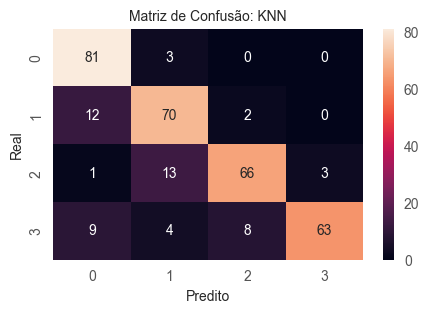

------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.96      0.87        84
           1       0.78      0.83      0.80        84
           2       0.87      0.80      0.83        83
           3       0.95      0.75      0.84        84

    accuracy                           0.84       335
   macro avg       0.85      0.84      0.84       335
weighted avg       0.85      0.84      0.84       335

------------------------------------------------------


In [21]:
print("="*54)
print(f'KNN')
print("="*54)
print(f"Tempo de execução do modelo: {round(tempo_total_knn, 3)} segundos")
print("-"*54)
print("Acurácia:", metrics.accuracy_score(y_test_class, y_pred_knn).round(3))
print("Precision:", metrics.precision_score(y_test_class, y_pred_knn, average = 'macro').round(3))
print("Recall:", metrics.recall_score(y_test_class, y_pred_knn, average = 'macro').round(3))

# Construindo matriz de confusão                                      
confusion_matrix = pd.crosstab(y_test_class, y_pred_knn, rownames = ['Real'], colnames = ['Predito'])
plt.figure(figsize=(5,3))
plt.title("Matriz de Confusão: KNN", fontsize=10)
sns.heatmap(confusion_matrix, annot=True)
plt.show()
print('-'*54)
print(metrics.classification_report(y_test_class, y_pred_knn))
print('-'*54)

### XGBoost

In [98]:
tempo_inic_xgb = time.time()

params = {'learning_rate': 0.1,
          'colsample_bytree' : 0.3,
          'max_depth': 10,
          'objective': 'binary:logistic',
          'alpha' : 10,
          'n_estimators': 100}

xgb = XGBClassifier(**params)

xgb.fit(x_train_preproc_class, y_train_class, 
        eval_set=[(x_train_preproc_class, y_train_class), (x_test_preproc_class, y_test_class)], 
        eval_metric='auc', verbose=False)

y_pred_xgb = xgb.predict(x_test_preproc_class)

tempo_final_xgb = time.time()

tempo_total_xgb = tempo_final_xgb - tempo_inic_xgb

XGBoost
Tempo de execução do modelo: 0.132 segundos
------------------------------------------------------
Acurácia: 0.827
Precision: 0.833
Recall: 0.827


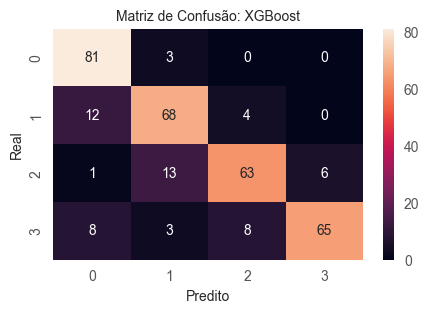

------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.96      0.87        84
           1       0.78      0.81      0.80        84
           2       0.84      0.76      0.80        83
           3       0.92      0.77      0.84        84

    accuracy                           0.83       335
   macro avg       0.83      0.83      0.83       335
weighted avg       0.83      0.83      0.83       335

------------------------------------------------------


In [99]:
print("="*54)
print(f'XGBoost')
print("="*54)
print(f"Tempo de execução do modelo: {round(tempo_total_xgb, 3)} segundos")
print("-"*54)
print("Acurácia:", metrics.accuracy_score(y_test_class, y_pred_xgb).round(3))
print("Precision:", metrics.precision_score(y_test_class, y_pred_xgb, average = 'macro').round(3))
print("Recall:", metrics.recall_score(y_test_class, y_pred_xgb, average = 'macro').round(3))

# Construindo matriz de confusão                                      
confusion_matrix = pd.crosstab(y_test_class, y_pred_xgb, rownames = ['Real'], colnames = ['Predito'])
plt.figure(figsize=(5,3))
plt.title("Matriz de Confusão: XGBoost", fontsize=10)
sns.heatmap(confusion_matrix, annot=True)
plt.show()
print('-'*54)
print(metrics.classification_report(y_test_class, y_pred_xgb))
print('-'*54)

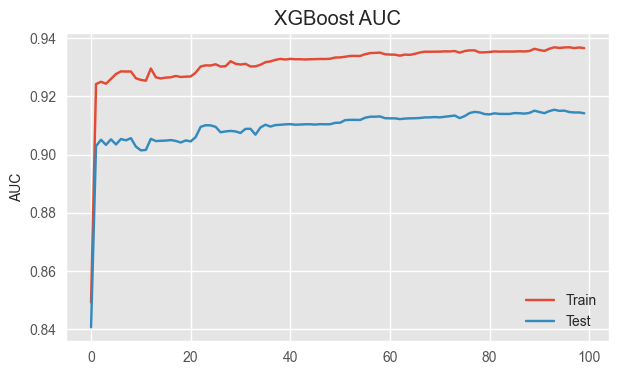

CPU times: total: 125 ms
Wall time: 249 ms


In [24]:
%%time
fig, ax = plt.subplots(figsize=(7,4))

evals_result = xgb.evals_result()
x_axis = range(0, len(evals_result['validation_0']['auc']))

ax.plot(x_axis, evals_result['validation_0']['auc'], label='Train')
ax.plot(x_axis, evals_result['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

### LightGBM

### CatBoost

## Sumarizando Resultados

In [25]:
modelo_dic = {
    "Árvore de Decisão" : {
        "Acurácia" : metrics.accuracy_score(y_test_class, y_pred_tree).round(3),
        "Precision" : metrics.precision_score(y_test_class, y_pred_tree, average = 'macro').round(3),
        "Recall" : metrics.recall_score(y_test_class, y_pred_tree, average = 'macro').round(3),
        "F1 score" : metrics.f1_score(y_test_class, y_pred_tree, average = 'macro').round(3),
        "Execução (s)": round(tempo_total_tree, 3)
    },
    "Random Forest" : {
        "Acurácia" : metrics.accuracy_score(y_test_class, y_pred_rnd).round(3),
        "Precision" : metrics.precision_score(y_test_class, y_pred_rnd, average = 'macro').round(3),
        "Recall" : metrics.recall_score(y_test_class, y_pred_rnd, average = 'macro').round(3),
        "F1 score" : metrics.f1_score(y_test_class, y_pred_rnd, average = 'macro').round(3),
        "Execução (s)": round(tempo_total_rnd, 3)
    },
    "SVM LIN" : {
        "Acurácia" : metrics.accuracy_score(y_test_class, y_pred_svmlin).round(3),
        "Precision" : metrics.precision_score(y_test_class, y_pred_svmlin, average = 'macro').round(3),
        "Recall" : metrics.recall_score(y_test_class, y_pred_svmlin, average = 'macro').round(3),
        "F1 score" : metrics.f1_score(y_test_class, y_pred_svmlin, average = 'macro').round(3),
        "Execução (s)": round(tempo_total_svmlin, 3)
    },
    "SVM RBF" : {
        "Acurácia" : metrics.accuracy_score(y_test_class, y_pred_svmrbf).round(3),
        "Precision" : metrics.precision_score(y_test_class, y_pred_svmrbf, average = 'macro').round(3),
        "Recall" : metrics.recall_score(y_test_class, y_pred_svmrbf, average = 'macro').round(3),
        "F1 score" : metrics.f1_score(y_test_class, y_pred_svmrbf, average = 'macro').round(3),
        "Execução (s)": round(tempo_total_svmrbf, 3)
    },
    "KNN" : {
        "Acurácia" : metrics.accuracy_score(y_test_class, y_pred_knn).round(3),
        "Precision" : metrics.precision_score(y_test_class, y_pred_knn, average = 'macro').round(3),
        "Recall" : metrics.recall_score(y_test_class, y_pred_knn, average = 'macro').round(3),
        "F1 score" : metrics.f1_score(y_test_class, y_pred_knn, average = 'macro').round(3),
        "Execução (s)": round(tempo_total_knn, 3)
    },
    "XGBoost" : {
        "Acurácia" : metrics.accuracy_score(y_test_class, y_pred_xgb).round(3),
        "Precision" : metrics.precision_score(y_test_class, y_pred_xgb, average = 'macro').round(3),
        "Recall" : metrics.recall_score(y_test_class, y_pred_xgb, average = 'macro').round(3),
        "F1 score" : metrics.f1_score(y_test_class, y_pred_xgb, average = 'macro').round(3),
        "Execução (s)": round(tempo_total_xgb, 3)
    },
}

In [26]:
resumo_classif = pd.DataFrame(modelo_dic)

resumo_classif = resumo_classif.T.sort_values(by = "F1 score", ascending = False)

In [27]:
resumo_classif

,Acurácia,Precision,Recall,F1 score,Execução (s)
KNN,0.836,0.847,0.836,0.835,0.027
SVM RBF,0.830,0.837,0.830,0.830,0.056
XGBoost,0.827,0.833,0.827,0.826,0.352
SVM LIN,0.821,0.826,0.821,0.821,0.030
Random Forest,0.821,0.831,0.821,0.820,0.480
Árvore de Decisão,0.791,0.796,0.791,0.789,0.012
